In [1]:
# execute to import notebook styling for tables and width etc.
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen('https://raw.githubusercontent.com/DataScienceUWL/DS775v2/master/ds755.css')
HTML(response.read().decode("utf-8"));

<font size=16>Lesson 03: Transportation Problems and More Abstract Formulations</font>

# Transportation Models

In Lesson 2 we presented a Supply and Demand problem as a Self-Assessment problem. That problem is actually a "transportation problem".  Transportation problems are characterized by having a set of "suppliers" and a set of "demanders".  The objects that are supplied can be goods or services.  

## Worker Scheduling as a Transportaton Problem

For example, in the Worker Scheduling problem (Textbook 3.4-15) the "suppliers" are the workers, the "demanders" are the days of the week on which workers must be scheduled, and the objects that are supplied are the hours of labor supplied by each worker.

Consider the graph shown below.  KC works or "transports" 2 hours to Monday and so on.  Recall also that each worker is only available during some of the days.  For instance KC is only available on Monday, Wednesday, and Friday.  In the graph there are no edges connecting KC to Tuesday or Thursday since KC can't work on those days.  In the solution code KC's availability is set to zero on Tuesday and Thursday as part of the constraints.

<img src="./images/worker_schedule.png" width = "400">

You can see how the graph was produced in section 1.1.3 if you wish.

### Explanation of Pyomo Solution (video)

The video below explores the connection between this scheduling problem and a transportation problem.  If you're content to study the code on you own, then you don't need to watch it. 

In [3]:
# execute this cell for video
from IPython.display import IFrame
IFrame(
    "https://media.uwex.edu/content/ds/ds775_r19/ds775_lesson3-transportation-problem-walkthrough/index.html",
    width=640,
    height=360)

### Pyomo Solution

In [4]:
# Solve the worker scheduling problem
from pyomo.environ import *
import pandas as pd

model = ConcreteModel()

workers = ['KC', 'DH', 'HB', 'SC', 'KS', 'NK']
min_hours = [8, 8, 8, 8, 7, 7]
hourly_rate = [25, 26, 24, 23, 28, 30]
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
hours_to_staff = [14, 14, 14, 14, 14]

min_hours_dict = dict(zip(workers, min_hours)) # zip two lists into dict
hourly_rate_dict = dict(zip(workers, hourly_rate))
hours_to_staff_dict = dict(zip(days, hours_to_staff))

hours_avail = [[6, 0, 6, 0, 6], [0, 6, 0, 6, 0], [4, 8, 4, 0, 4],
               [5, 5, 5, 0, 5], [3, 0, 3, 8, 0], [0, 0, 0, 6, 2]]

# convert nested list (indexed by integers) 
# to nested dictionary (indexed by index sets)
hours_avail_dict = {
    workers[w]: dict( zip( days, hours_avail[w][:]) )
    for w in range(len(workers))
}

# instantiate Concrete Model
model = ConcreteModel()

# define variables
model.hrs = Var(workers, days, domain=NonNegativeReals)

# define objective function
model.total_cost = Objective(expr=sum(hourly_rate_dict[w] * model.hrs[w, d]
                                      for w in workers for d in days),
                             sense=minimize)

# define constraints
model.supply_ct = ConstraintList()
for w in workers:
    model.supply_ct.add(sum(model.hrs[w, d] for d in days) >= min_hours_dict[w])

model.demand_ct = ConstraintList()
for d in days:
    model.demand_ct.add(
        sum(model.hrs[w, d] for w in workers) == hours_to_staff_dict[d])

model.avail_ct = ConstraintList()
for w in workers:
    for d in days:
        model.avail_ct.add(model.hrs[w, d] <= hours_avail_dict[w][d])

# solve
solver = SolverFactory('glpk')
solver.solve(model)

# convert model.hrs into a Pandas data frame for nicer display
schedule = pd.DataFrame([[model.hrs[w, d].value for d in days]
                         for w in workers],
                        index=workers,
                        columns=days)

# display
import babel.numbers as numbers  # needed to display as currency
print("The minimum total weekly cost = ",
      numbers.format_currency(model.total_cost(), 'USD', locale='en_US'))
print("The number of hours to schedule for each worker is: ")
schedule

The minimum total weekly cost =  $1,755.00
The number of hours to schedule for each worker is: 


,Mon,Tue,Wed,Thu,Fri
KC,2.0,0.0,4.0,0.0,3.0
DH,0.0,2.0,0.0,6.0,0.0
HB,4.0,7.0,4.0,0.0,4.0
SC,5.0,5.0,5.0,0.0,5.0
KS,3.0,0.0,1.0,3.0,0.0
NK,0.0,0.0,0.0,5.0,2.0


### Visualization

We use a graph to visualize the solution below.  You don't really have to do this in the homework, but we include it in case it's helpful to improve your understanding.   

In [5]:
# function to show bipartite graph, not important to understand

%matplotlib notebook
import networkx as nx
import matplotlib.pyplot as plt

def graph_bipartite(left,right,edges={},labels={}):
    g = nx.Graph()
    g.add_nodes_from( left,bipartite=0)
    g.add_nodes_from(right,bipartite=1)

    if len(edges)>0:
        edges_new = edges
    else:
        edges_new = [(l,r) for l in left for r in right]
 
    for e in edges_new:
        g.add_edge(e[0],e[1])

    nleft = len(left)
    xw = .1
    eshift_left = .02
    delta_y = 1/(nleft+1)
    pos_left = { left[i]:(xw, 1-delta_y * (i+1)) for i in range(nleft) }
    pos_left_edge = { left[i]:(xw+eshift_left, 1-delta_y * (i+1)) for i in range(nleft) }
    xw = .1

    nright = len(right)
    xs = .9
    eshift_right = .015
    delta_y = 1/(nright+1)
    pos_right = { right[i]:(xs, 1-delta_y * (i+1)) for i in range(nright) }
    pos_right_edge = { right[i]:(xs-eshift_right, 1-delta_y * (i+1)) for i in range(nright) }

    plt.rcParams['figure.figsize'] = [7, 7]
    plt.axis('off')

    nx.draw_networkx_nodes( left, pos_left,nodelist= left,node_color='r',node_size=0,alpha=0.3)
    nx.draw_networkx_nodes(right,pos_right,nodelist=right,node_color='b',node_size=0,alpha=0.3)

    pos = {}
    pos.update(pos_left)
    pos.update(pos_right)

    nx.draw_networkx_labels(g,pos,font_size=10,font_family='sans-serif')

    pos_e = {}
    pos_e.update(pos_left_edge)
    pos_e.update(pos_right_edge)
    
    nx.draw_networkx_edges(g,pos_e,edgelist=edges_new,width=1,alpha=0.4,edge_color='b')
    
    if len(labels)>0:        
        label_dict = dict(zip(edges_new,labels))
        nx.draw_networkx_edge_labels(g,pos_e,edge_labels=labels,font_color='red',font_size = 8, label_pos=.85)


<IPython.core.display.Javascript object>


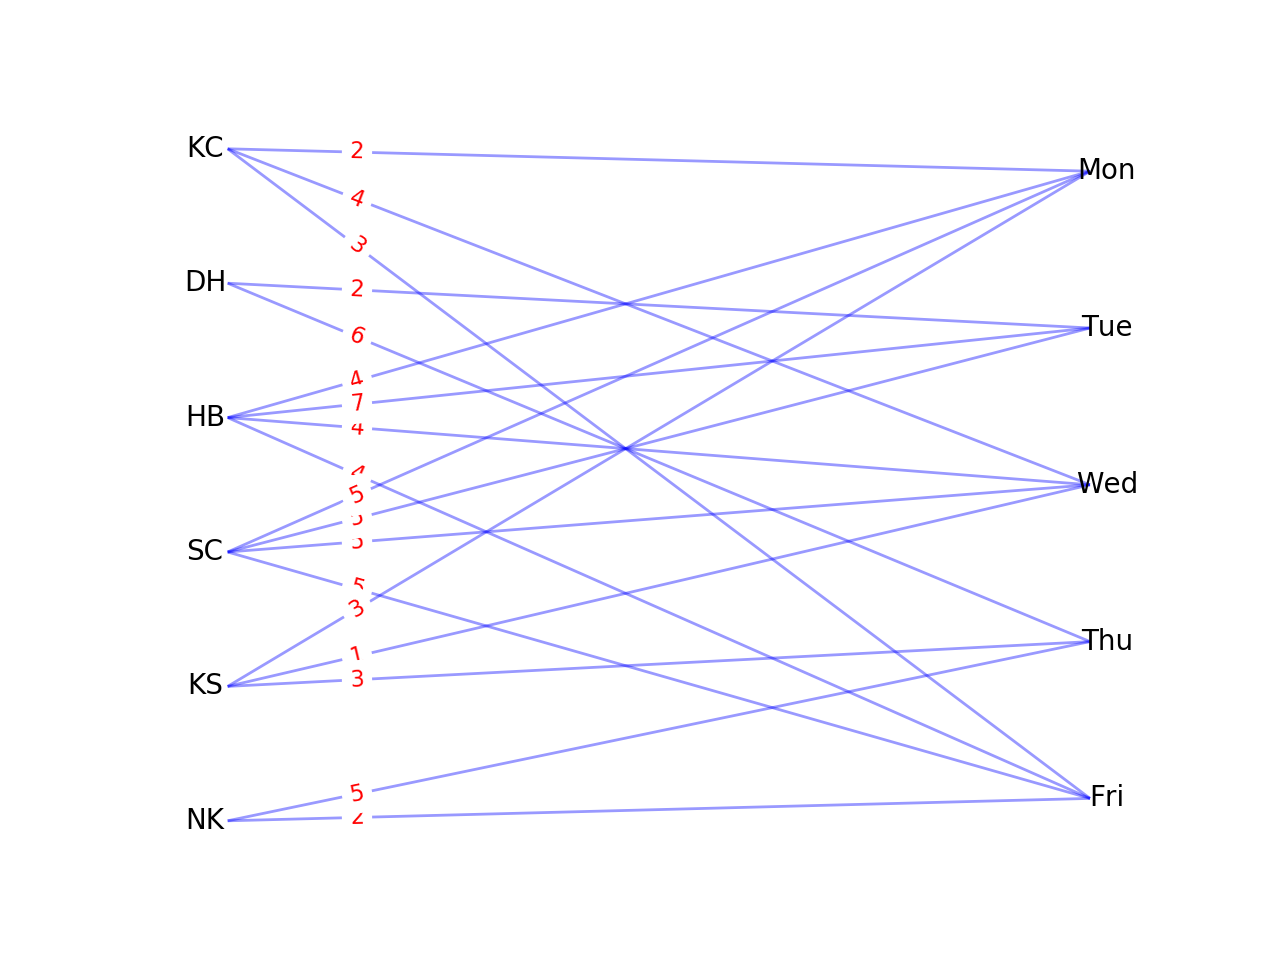

In [6]:
# Visualization of schedule
workers_days = {(w, d)
                for w in workers for d in days if hours_avail_dict[w][d] > 0}
workers_days_labels = {(w, d):'{:d}'.format(int(model.hrs[w, d].value))
                       for (w, d) in workers_days}
plt.figure()
graph_bipartite(workers, days, workers_days, workers_days_labels)

## <font color = "blue">Self-Assessment: Cheaper Schedule?</font>

For the worker scheduling problem management now insists that each worker be available for up to 8 hours on each day.  Copy the code above into a new cell  and modify it to solve this new problem.  How much lower is the total cost?  Which worker gets assigned the most hours?  Why does one worker get so many hours?

## Prototypical Transportation Example from Textbook

You should read the complete details of this problem beginning on page 319 of the textbook.  In short we want to transport truckloads of canned peas from canneries to warehouses.  The supply (Output), demand (Allocation), and shipping cost per truckload are shown in this table:

<img src="images/prototype_transport.png" width="600">

This is an example of a **balanced** transportation problem because the total supply equals, or is balanced by, the total demand.

### Mathematical Formulation

Mathematically we can frame the problem as below (identical to page 324). 

Let $C$ be the set of canneries and let $W$ be the set of warehouses.

Decision Variables:  let $x_{c,w}$ be the number of units shipped from cannery $c \in C$ to warehouse $w \in W$

Constants:  
- $q_{c,w}$ is the shipping cost per unit between factory $c \in C$ and warehouse $w \in W$
- $d_w$ is the number of units demanded by warehouse $w \in W$
- $s_c$ is the number of units supplied by cannery $c \in C$

Objective Function:  minimize $ Cost = \displaystyle \sum_{c \in C} \sum_{w \in W} q_{c,w} x_{c,w}$

Constraints:
- Supply: $ \displaystyle \sum_{w \in W} x_{c,w} = s_c, \mbox{ for each } c \in C$
- Demand: $ \displaystyle \sum_{c \in C} x_{c,w} = d_w, \mbox{ for each } w \in W$
- Nonnegativity: $x_{c,w} \geq 0$ for each $c \in C, w \in W$

### Integer Solutions Property

For transportation and assignment problems *if the amounts supplied and demanded are integer valued, then the solutions will always be integers.*

This is super important because it allows us to use the Simplex method or other LP solvers to achieve integer valued solutions even if we allow real numbers for the decision variables.  If we restrict the decision variables to be integer valued, then the the solution procedure is much more computationally intensive.  We'll discuss this in a later lesson about Integer Programming.

### Pyomo Solution

In [ ]:
canneries = ['can1', 'can2','can3']
supply = dict(zip(canneries, [75, 125, 100]))

warehouses = ['ware1','ware2','ware3','ware4']
demand = dict(zip(warehouses, [80, 65, 70, 85]))

usc = [[464, 513, 654, 867], [352, 416, 690, 791],
       [995, 682, 388, 685] ]
unit_ship_cost = {
    canneries[c]: {warehouses[w]: usc[c][w]
                   for w in range(len(warehouses))}
    for c in range(len(canneries))
}

# throw an error if total supply and demand do not match
assert (sum(supply.values()) == sum(demand.values()))

from pyomo.environ import *

model = ConcreteModel()

model.transp = Var(canneries, warehouses, domain=NonNegativeReals)

model.total_cost = Objective(expr=sum(unit_ship_cost[c][w] * model.transp[c, w]
                                      for c in canneries for w in warehouses),
                             sense=minimize)

model.supply_ct = ConstraintList()
for c in canneries:
    model.supply_ct.add(
        sum(model.transp[c, w] for w in warehouses) == supply[c])

model.demand_ct = ConstraintList()
for w in warehouses:
    model.demand_ct.add(
        sum(model.transp[c, w] for c in canneries) == demand[w])

# solve and display
solver = SolverFactory('glpk')
solver.solve(model)

# display solution
import babel.numbers as numbers  # needed to display as currency
print("Minimum Total Cost = ",
      numbers.format_currency(model.total_cost(), 'USD', locale='en_US'))
# put amounts in dataframe for nicer display
import pandas as pd
dvars = pd.DataFrame([[model.transp[c, w]() for w in warehouses]
                      for c in canneries],
                     index=canneries,
                     columns=warehouses)
print("Number of truckloads to ship from each cannery to each warehouse:")
dvars

<IPython.core.display.Javascript object>


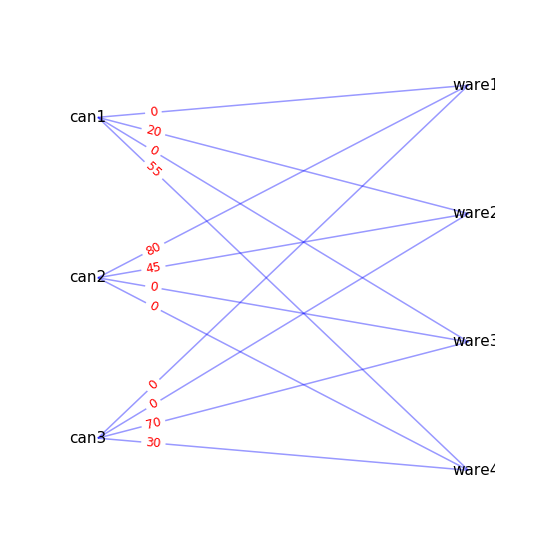

In [48]:
# code for visualizing the solution, not very important
canneries_wares = {(c, w) for c in canneries for w in warehouses}
canneries_wares_labels = {(c, w):
                          '{:d}'.format(int(model.transp[c, w].value))
                          for (c, w) in canneries_wares}
plt.figure()
graph_bipartite(canneries, warehouses, canneries_wares, canneries_wares_labels)

## <font color = "blue">Self-Assessment: Unbalanced Transportation Problem</font>

This example is modeled after a problem found in Practical Management Science by Wayne L. Winston and S. Christian Albright.  

International Textile Company, Ltd, Kong–based firm that distributes textiles world- wide. They have mills for weaving bolts of cotton fabric in the Bahamas, Hong Kong, Korea, Nigeria, and Venezuela.  The mills ship bolts of cotton to distribution eight distribution centers (listed below).

The company is owned by the Lao family. Present plans are to remain in Hong Kong through the transition in governments. Should the People’s Republic of China continue its economic renaissance, the company hopes to use its current base to expand operations to the mainland. International Textile has mills in the Bahamas, Hong Kong, Korea, Nigeria, and Venezuela, each weaving fabrics out of two or more raw fibers: cotton, polyester, and/or silk. The mills service eight company distribution centers.  Cotton supplies and demands at the distribution center are shown below.  Shipping costs depend on both distances and other factors and are shown below.  

We want to minimize the total shipping cost, however this is an **unbalanced** transportation problem (there is more supply than demand for cotton bolts).  To turn this into a balanced problem so that our previous code can be applied add an extra distribution center called 'Dummy' to absorb the extra supply.  Set the demand at the dummy distribution center so that total supply and total demand are balanced.  You can learn more here: <a href="https://www.wisdomjobs.com/e-university/quantitative-techniques-for-management-tutorial-297/unbalanced-transportation-problem-9888.html">Unbalanced Transportation Problems</a>. Finally, set the costs of shipping to the dummy distribution center since nothing will actually be shipped.

After balancing the problem solve the transportation problem to minimize the total shipping cost.  You don't have to retype the data, you can use the dictionaries defined in the following three cells.

In [111]:
# Shipping_Cost per Route (rows = Mills, cols = Distribution Centers)
import pandas as pd
mills = ['Bahamas', 'Hong Kong', 'Korea', 'Nigeria', 'Venezuela']
dist_ctrs = [
    'Los Angeles', 'Chicago', 'London', 'Mexico City', 'Manila', 'Rome',
    'Tokyo', 'New York'
]
ship_cost = [[2, 2, 3, 3, 7, 4, 7, 1], [6, 7, 8, 10, 2, 9, 4, 8],
             [5, 6, 8, 11, 4, 9, 1, 7], [14, 12, 6, 9, 11, 7, 5, 10],
             [4, 3, 5, 1, 9, 6, 11, 4]]
ship_cost_dict = {
    mills[m]: dict(zip(dist_ctrs, ship_cost[m][:]))
    for m in range(len(mills))
}

# for display
pd.DataFrame(ship_cost_dict).transpose()

,Chicago,London,Los Angeles,Manila,Mexico City,New York,Rome,Tokyo
Bahamas,2,3,2,7,3,1,4,7
Hong Kong,7,8,6,2,10,8,9,4
Korea,6,8,5,4,11,7,9,1
Nigeria,12,6,14,11,9,10,7,5
Venezuela,3,5,4,9,1,4,6,11


In [112]:
# max supply
max_supply = dict( zip( mills, [1000, 2000, 1000, 2000, 1000]) )

# using Pandas for neater display
pd.DataFrame.from_dict(max_supply,orient="index",columns=['Cotton Bolts'])

,Cotton Bolts
Bahamas,1000
Hong Kong,2000
Korea,1000
Nigeria,2000
Venezuela,1000


In [113]:
# demand
demand = dict( zip( dist_ctrs,[ 500, 800, 900, 900, 800, 100, 200, 700]) )

# using Pandas for display
pd.DataFrame.from_dict(demand,orient="index",columns=['Cotton Bolts'])

,Cotton Bolts
Los Angeles,500
Chicago,800
London,900
Mexico City,900
Manila,800
Rome,100
Tokyo,200
New York,700


## Dealing with Infeasible Routes

It often happens in transportation problems that due to problems or prohibitive costs, shipping is not available on along certain routes.  

For instance, in the Prototypical Example above, suppose that we cannot ship between Cannery 1 and Warehouse 2, between Cannery 2 and Warehouse 1, or between Cannery 3 and Warehouse 3.  The table below shows the shipping costs with 'X' representing infeasible routes.

<img src="images/prototype_transport_x.png" width="600">

There are at least three techniques for representing the infeasible routes:

### Overview of Techniques (video)

In [2]:
# execute this cell for video
from IPython.display import IFrame
IFrame(
    "https://media.uwex.edu/content/ds/ds775_r19/ds775_lesson3-dealing-with-infeasible-routes/index.html",
    width=640,
    height=360)

### Technique 1: The "Big M" Method

Introduce a large value of the cost, "big $M$", on those routes that are infeasible.  If those costs are large enough, then the optimization will be forced to use zeros for the corresponding decision variables to minimize the cost.  Choose a value for $M$ that is perhaps 10 or 100 times larger than the largest cost.  Making $M$ ridiculously large can lead to numerical issues in the underlying solution method while choosing $M$ too small may lead to incorrect results.  **Always inspect your solution to make sure it makes sense.  Are there zero amounts transported along the infeasible routes?**

Here is the python code from the Protypical Example above adapted use the big $M$ method.

In [131]:
canneries = ['can1', 'can2','can3']
supply = dict(zip(canneries, [75, 125, 100]))

warehouses = ['ware1','ware2','ware3','ware4']
demand = dict(zip(warehouses, [80, 65, 70, 85]))

###########################################################
### only modification to code is here in unit_ship_cost ###
###########################################################
bigM = 10000;
usc = [[464, bigM, 654, 867], [bigM, 416, 690, 791],
       [995, 682, bigM, 685] ]
unit_ship_cost = {
    canneries[c]: {warehouses[w]: usc[c][w]
                   for w in range(len(warehouses))}
    for c in range(len(canneries))
}

# throw an error if total supply and demand do not match
assert (sum(supply.values()) == sum(demand.values()))

from pyomo.environ import *

model = ConcreteModel()

model.transp = Var(canneries, warehouses, domain=NonNegativeReals)

model.total_cost = Objective(expr=sum(unit_ship_cost[c][w] * model.transp[c, w]
                                      for c in canneries for w in warehouses),
                             sense=minimize)

model.supply_ct = ConstraintList()
for c in canneries:
    model.supply_ct.add(
        sum(model.transp[c, w] for w in warehouses) == supply[c])

model.demand_ct = ConstraintList()
for w in warehouses:
    model.demand_ct.add(
        sum(model.transp[c, w] for c in canneries) == demand[w])

# solve and display
solver = SolverFactory('glpk')
solver.solve(model)

# display solution
import babel.numbers as numbers  # needed to display as currency
print("Minimum Total Cost = ",
      numbers.format_currency(model.total_cost(), 'USD', locale='en_US'))
# put amounts in dataframe for nicer display
import pandas as pd
dvars = pd.DataFrame([[model.transp[c, w]() for w in warehouses]
                      for c in canneries],
                     index=canneries,
                     columns=warehouses)
print("Number of truckloads to ship from each cannery to each warehouse:")
dvars

Minimum Total Cost =  $176,000.00
Number of truckloads to ship from each cannery to each warehouse:


,ware1,ware2,ware3,ware4
can1,75.0,0.0,0.0,0.0
can2,0.0,55.0,70.0,0.0
can3,5.0,10.0,0.0,85.0


Note that the new solution has zero truckloads transported along the infeasible routes.  Also, the minimum total cost has increased as the solution is forced to use more expensive routes.

The "big M" method is simple, but because in complex problems it can be hard to choose the right value for $M$ without introducing numerical errors it probably isn't the best method available.  However, for simple problems such as this one it works just fine.

### Technique 2:  Use Extra Constraints

This technique is straightforward.  Just add additional constraints that set the transported amounts to zero along the infeasible routes.  Below we've modified the Prototypical Example python solution with extra constraints.

In [1]:
canneries = ['can1', 'can2', 'can3']
supply = dict(zip(canneries, [75, 125, 100]))

warehouses = ['ware1', 'ware2', 'ware3', 'ware4']
demand = dict(zip(warehouses, [80, 65, 70, 85]))

usc = [[464, 513, 654, 867], [352, 416, 690, 791], [995, 682, 388, 685]]
unit_ship_cost = {
    canneries[c]: {warehouses[w]: usc[c][w]
                   for w in range(len(warehouses))}
    for c in range(len(canneries))
}

# throw an error if total supply and demand do not match
assert (sum(supply.values()) == sum(demand.values()))

from pyomo.environ import *

model = ConcreteModel()

model.transp = Var(canneries, warehouses, domain=NonNegativeReals)

model.total_cost = Objective(expr=sum(unit_ship_cost[c][w] * model.transp[c, w]
                                      for c in canneries for w in warehouses),
                             sense=minimize)

model.supply_ct = ConstraintList()
for c in canneries:
    model.supply_ct.add(
        sum(model.transp[c, w] for w in warehouses) == supply[c])

model.demand_ct = ConstraintList()
for w in warehouses:
    model.demand_ct.add(
        sum(model.transp[c, w] for c in canneries) == demand[w])

######################################################
### additional constraints here.  no other changes ###
######################################################
no_transport = {('can1','ware2'),('can2','ware1'),('can3','ware3')}
model.no_ship_ct = ConstraintList()
for (c,w) in no_transport:
    model.no_ship_ct.add(model.transp[c,w]==0)

# solve and display
solver = SolverFactory('glpk')
solver.solve(model)

# display solution
import babel.numbers as numbers  # needed to display as currency
print("Minimum Total Cost = ",
      numbers.format_currency(model.total_cost(), 'USD', locale='en_US'))
# put amounts in dataframe for nicer display
import pandas as pd
dvars = pd.DataFrame([[model.transp[c, w]() for w in warehouses]
                      for c in canneries],
                     index=canneries,
                     columns=warehouses)
print("Number of truckloads to ship from each cannery to each warehouse:")
dvars

Minimum Total Cost =  $176,000.00
Number of truckloads to ship from each cannery to each warehouse:


,ware1,ware2,ware3,ware4
can1,75.0,0.0,0.0,0.0
can2,0.0,55.0,70.0,0.0
can3,5.0,10.0,0.0,85.0


This technique is clean but does introduce extra constraints.  This really isn't a big deal for small problems, but for large problems it can add a lot of unnecessary computational complexity.  The best solution for large problems is explained in the next section.

### Technique 3:  Eliminate Unnecessary Decision Variables

Since we already know the amounts shipped along the infeasible routes will be zero we really don't need decision variables for those amounts.  We could just introduce decision variables for those routes we need, but we want to do this in an automated way instead of typing out a bunch of individual variables.  This technique is the most difficult but has a huge computational advantage for large problems with lots of infeasible routes. 

A nice way to do this is make a list of tuples for the feasible routes and then create a dictionary that uses those tuples as keys to look up the unit shipping cost values.  We'll then use those tuples as the index set for our decision variables.

Here is one way to setup the list of tuples and the dictionary.  

In [134]:
can_ware_routes = [('can1', 'ware1'), ('can1', 'ware3'), ('can1', 'ware4'),
                   ('can2', 'ware2'), ('can2', 'ware3'), ('can2', 'ware4'),
                   ('can3', 'ware1'), ('can3', 'ware2'), ('can3', 'ware4')]
unit_ship_cost = [464, 654, 867, 416, 690, 791, 995, 682, 685]
unit_ship_cost_dict = dict(zip(can_ware_routes, unit_ship_cost))
unit_ship_cost_dict

{('can1', 'ware1'): 464,
 ('can1', 'ware3'): 654,
 ('can1', 'ware4'): 867,
 ('can2', 'ware2'): 416,
 ('can2', 'ware3'): 690,
 ('can2', 'ware4'): 791,
 ('can3', 'ware1'): 995,
 ('can3', 'ware2'): 682,
 ('can3', 'ware4'): 685}

For a large problem we wouldn't want to have to type all of that out and would likely read it from another source.  If we have a table that already has the costs in it along with a way of designating the infeasible routes, then we can create the tuples and dictionary like this:

In [13]:
# infeasible routes have large cost values in our table
bigM = 10000
usc = [[464, bigM, 654, 867], [bigM, 416, 690, 791], [995, 682, bigM, 685]]

# convert to a dataframe as an intermediate step to simplify the code
import pandas as pd
usc_df = pd.DataFrame(usc, columns=warehouses, index=canneries)

# now we can access the unit shipping costs like usc_df.loc['can1','ware1']
unit_ship_cost = {(c, w): usc_df.loc[c, w]
                  for c in canneries for w in warehouses
                  if usc_df.loc[c, w] < bigM}

We can get the list of tuples from the dictionary keys:

In [7]:
can_ware_routes = list(unit_ship_cost.keys())
can_ware_routes

[('can1', 'ware1'),
 ('can1', 'ware3'),
 ('can1', 'ware4'),
 ('can2', 'ware2'),
 ('can2', 'ware3'),
 ('can2', 'ware4'),
 ('can3', 'ware1'),
 ('can3', 'ware2'),
 ('can3', 'ware4')]

Now here is the modified python to utilize only the needed decision variables.  We've included the list of tuples and dictionary for completeness.

In [12]:
canneries = ['can1', 'can2', 'can3']
supply = dict(zip(canneries, [75, 125, 100]))

warehouses = ['ware1', 'ware2', 'ware3', 'ware4']
demand = dict(zip(warehouses, [80, 65, 70, 85]))

#########################
# tuples and dictionary #
#########################
can_ware_routes = [('can1', 'ware1'), ('can1', 'ware3'), ('can1', 'ware4'),
                   ('can2', 'ware2'), ('can2', 'ware3'), ('can2', 'ware4'),
                   ('can3', 'ware1'), ('can3', 'ware2'), ('can3', 'ware4')]
usc = [464, 654, 867, 416, 690, 791, 995, 682, 685]
unit_ship_cost = dict(zip(can_ware_routes, usc))

# throw an error if total supply and demand do not match
assert (sum(supply.values()) == sum(demand.values()))

from pyomo.environ import *

model = ConcreteModel()

###########################################################################
# use the list of tuples of routes as the index for the decision variable #
###########################################################################
model.transp = Var(can_ware_routes, domain=NonNegativeReals)

#################################################################
# the list of tuples is also used to sum the objective function #
# you can write unit_ship_cost[(c,w)] or unit_ship_cost[c,w]    #
#################################################################
model.total_cost = Objective(expr=sum(unit_ship_cost[c, w] * model.transp[c, w]
                                      for (c, w) in can_ware_routes),
                             sense=minimize)

#####################################################################
# use an extra if statement in the sum to include only valid routes #
#####################################################################
model.supply_ct = ConstraintList()
for c in canneries:
    model.supply_ct.add(
        sum(model.transp[c, w] for w in warehouses
            if (c, w) in can_ware_routes) == supply[c])

model.demand_ct = ConstraintList()
for w in warehouses:
    model.demand_ct.add(
        sum(model.transp[c, w] for c in canneries
            if (c, w) in can_ware_routes) == demand[w])

# solve and display
solver = SolverFactory('glpk')
solver.solve(model)

# display solution
import babel.numbers as numbers  # needed to display as currency
print("Minimum Total Cost = ",
      numbers.format_currency(model.total_cost(), 'USD', locale='en_US'))

print("\nTransported Amounts:")
for (c, w) in can_ware_routes:
    print("Ship {0:d} truckloads from {1:s} to {2:s}".format(
        int(model.transp[c, w].value), c, w))

# or can setup a data frame for nicer display, use zeros for infeasible routes
print("\nData Frame display of transported amounts:")
import pandas as pd
transp = pd.DataFrame(0, index=canneries, columns=warehouses)
for (c,w) in can_ware_routes:
    transp.loc[c,w] = model.transp[c,w].value
transp

Minimum Total Cost =  $176,000.00

Transported Amounts:
Ship 75 truckloads from can1 to ware1
Ship 0 truckloads from can1 to ware3
Ship 0 truckloads from can1 to ware4
Ship 55 truckloads from can2 to ware2
Ship 70 truckloads from can2 to ware3
Ship 0 truckloads from can2 to ware4
Ship 5 truckloads from can3 to ware1
Ship 10 truckloads from can3 to ware2
Ship 85 truckloads from can3 to ware4

Data Frame display of transported amounts:


,ware1,ware2,ware3,ware4
can1,75.0,0.0,0.0,0.0
can2,0.0,55.0,70.0,0.0
can3,5.0,10.0,0.0,85.0


## <font color="blue">Self-Assessment:  Remove unneeded variables</font>

Revisit the worker scheduling problem from the textbook (3.4-15).  Start with the code above and modify it using Technique 3 to eliminate unneeded decision variables.  Your new solution should have 18 decision variables instead of 30 and the overall answer should be the same.

## Transporting Multiple Products

To move toward making a more realistic problem we consider a transportation problem in which multiple products are transported from suppliers to customers.  To accomplish this our decision variables will need to be indexed by three sets:  product, supplier, and customer.  Like this:  

```model.transp[ product, supplier, customer ]```

You can think of this as a three-dimensional array which in turn can be thought of as a stack of two-dimensional arrays:

<img src="./images/threeD_array.png" width = "400">

Image from <a href="http://c-programmingbooks.blogspot.com/2011/11/three-dimensional-array-in-c.html">c-programmingbooks.blogspot.com</a>

The 0th 2D array corresponds to the first product while the rows and columns of that array correspond to suppliers and customers respectively.  According to the picture, 4 units of product 1 are shipped from supplier number 1 to customer number 2.  To find the cost of shipping the products we have to sum the cost per unit times the number of units over all the elements in the three dimensional array, like this:

```sum(cost[p,s,c] * model.transp[p,s,c] for p in products for s in suppliers for c in customers)```

A supply constraint means that total amount of each product shipped from each supplier must match the supply available.  

```
for p in products:
    for s in suppliers:
        sum( model.transp[p,s,c] for c in customers) == supply[p,s] )
```
In the picture above this corresponds to summing each row of the stacked 2D arrays to make sure it matches the supplied amount.

If limited capacity is available for shipping from each supplier to each customer we have to add up the total amount of all products to be sure it isn't too large:
```
for s in supplier:
    for c in customer:
        sum( model.transp[p,s,c] for p in products ) <= capacity )
```

Suppose we are solving an inventory problem for a large retail chain in which the suppliers are warehouses or distribution centers and the customers are the individual retail stores or outlets.  Each warehouse only serves a subset of the stores to minimize shipping costs.   We won't need decision variables for those routes that are infeasible so we'll use Technique 3 to reduce the number of decision variables.  The next self-assessment problem has you complete the code to solve a multi-product transportation problem.  This video discusses some of the code:


### Video walkthrough of code for self-assessment below

In [1]:
# execute this cell for video
from IPython.display import IFrame
IFrame(
    "https://media.uwex.edu/content/ds/ds775_r19/ds775_lesson3-transportation-problem-walkthrough3/index.html",
    width=640,
    height=360)

## <font color="blue">Self-Assessment: Multiple Products</font>

Products A and B are supplied by warehouses wA, wB, wC to stores sA, sB, sC, sD, sE.  The supply, demand, shipping capacity, and shipping cost per unit (dollars per unit) are shown in the Excel spreadsheet `transp_prob_multi.xlsx` in the data subfolder.  Some of the code for the pyomo solution is shown below including details of how to read the data from the Excel file.  Complete the code to minimize the total shipping cost.  Hint:  the answer is \$23,700.

In [ ]:
# using openpyxl
from openpyxl import load_workbook
wb = load_workbook(filename='data/transp_prob_multi.xlsx', data_only=True)
sheet = wb.active

# specify upper left and lower right cells, returns a list or list of lists representing rows
# for a single value read_range(sheet,'A11')
# for a list of values in a column or row read_range(sheet,'A11','N11')
# for nested lists of values (array-like) read_range(sheet,'A11','D23')
def read_range(sheet, begin, *argv):
    if len(argv)>0:
        end = argv[0]
        table = sheet[begin:end]
        height = len(table)
        width = len(table[0])
        if height == 1 or width == 1:
            # for a single row or column produce a list
            tmp = [cell.value for row in table for cell in row]
        else:
            # for an array of cells produces a list of row lists
            tmp = [[cell.value for cell in row] for row in table]
    else:
        tmp = sheet[begin].value
    return (tmp)

warehouses = read_range(sheet, 'A3', 'A5')
stores = read_range(sheet, 'B3', 'B7')
products = read_range(sheet, 'C3', 'C4')
# all feasible product-warehouse-store combinations
routes = {(p, w, s) for [p, w, s] in read_range(sheet, 'E3', 'G20')}
# all feasible warehouse-store combinations
wares_stores = {(w,s) for (p,w,s) in routes}
capacity = read_range(sheet, 'A11')
cost = {(p, w, s): c for [p, w, s, c] in read_range(sheet, 'E3', 'H20')}
supply = {(p, w): q for [p, w, q] in read_range(sheet, 'J3', 'L8')}
demand = {(p, s): q for [p, s, q] in read_range(sheet, 'N3', 'P12')}

# throw an error if total supply and demand do not match
for p in products:
    assert (sum(supply[p, w] for w in warehouses
                if (p, w) in supply.keys()) == sum(demand[p, s]
                                                   for s in stores
                                                   if (p, s) in demand.keys()))

from pyomo.environ import *

model = ConcreteModel()

model.transp = Var(routes, domain=NonNegativeReals) # one decions variable for each feasible p-w-s combo

model.total_cost = Objective(expr=sum(cost[p,w,s] * model.transp[p,w,s] for (p,w,s) in routes) )

model.supply_ct = ConstraintList()
for p in products:
    for w in warehouses:
        # the if statement allows only feasible p-w-s combos in the sum
        model.supply_ct.add( sum( model.transp[p,w,s] for s in stores if (p,w,s) in routes) == supply[p,w] )


model.demand_ct = ConstraintList()
# COMPLETE the demand constraint, for each product and store the total transported must ....

model.capacity_ct = ConstraintList()
for (w,s) in wares_stores:
    # COMPLETE - add up the transported amounts of all the products shipped from w to s, make sure p-w-s combo is feasible
    # using an if statement

# solve and display
solver = SolverFactory('glpk')
solver.solve(model)

# convert model.hrs into a Pandas data frame for nicer display
import pandas as pd
transp_pA = pd.DataFrame(0, index=warehouses, columns=stores)
transp_pB = pd.DataFrame(0, index=warehouses, columns=stores)
for (w, s) in wares_stores:
    transp_pA.loc[w, s] = model.transp['pA', w, s].value
    transp_pB.loc[w, s] = model.transp['pB', w, s].value

# display
import babel.numbers as numbers  # needed to display as currency
print("The minimum total transportation cost = ",
      numbers.format_currency(model.total_cost(), 'USD', locale='en_US'))

from IPython.display import display
print("\nThe transported amounts of product A: ")
display(transp_pA)
print("\nThe transported amounts of product B: ")
display(transp_pB)

We like to think of an assignment problem as a transportation problem in which we are transporting objects to destinations.  Assigning workers to jobs can be transporting workers to jobs where each worker has a supply of 1 and each job has a demand of 1.  To solve assignment problems as linear programs the supply and demand must match, that is the problem must be balanced.  In other words we need the same number of workers as jobs.  If the problem isn't balanced then we can add dummy workers or dummy jobs to balance the problem.

## Prototypical Assignment Problem

This problem is described completely on page 348 of the textbook.  We're including it here as an example to show how to solve it using Pyomo.  In short, we're assigning 3 machines to 4 locations.  Because this is imbalanced, a 4th dummy machine is added.  Each machine has an hourly cost that depends on the location.  Machine 2 cannot be used in location 2 and there is no cost associated with assigning the dummy machine to any location since this just means that no machine is installed at that location.  The mathematical formulation is identical to that of the transportation problem using a supply and demand of 1 at each machine and location. The cost table is shown here for convenience:

<img src="images/table_9p25.png" width="400">

The $M$ will be a very large value ("big M") to prevent an assignment of machine 2 to location 2.

Here is a Pyomo solution:

In [15]:
machines = ['mac1', 'mac2', 'mac3', 'macD']
supply = dict(zip(machines, [1, 1, 1, 1]))

locations = ['loc1', 'loc2', 'loc3', 'loc4']
demand = dict(zip(locations, [1, 1, 1, 1]))

bigM = 1000
cost_list = [[13,16,12,11],[15,bigM,13,20],[5,7,10,6],[0,0,0,0]]
cost = {
    machines[m]: {locations[l]: cost_list[m][l]
                   for l in range(len(locations))}
    for m in range(len(machines))
}

# throw an error if total supply and demand do not match
assert (sum(supply.values()) == sum(demand.values()))

from pyomo.environ import *

model = ConcreteModel()

model.assign= Var(machines, locations, domain=NonNegativeReals)

model.total_cost = Objective(expr=sum(cost[m][l] * model.assign[m, l]
                                      for m in machines for l in locations),
                             sense=minimize)

model.supply_ct = ConstraintList()
for m in machines:
    model.supply_ct.add(
        sum(model.assign[m, l] for l in locations) == supply[m])

model.demand_ct = ConstraintList()
for l in locations:
    model.demand_ct.add(
        sum(model.assign[m, l
                        ] for m in machines) == demand[l])

# solve and display
solver = SolverFactory('glpk')
solver.solve(model)

# display solution
import babel.numbers as numbers  # needed to display as currency
print("Minimum Cost per hour = ",
      numbers.format_currency(model.total_cost(), 'USD', locale='en_US'))
# put amounts in dataframe for nicer display
import pandas as pd
dvars = pd.DataFrame([[model.assign[m, l]() for l in locations]
                      for m in machines],
                     index = machines,
                     columns=locations)
print("Machine assignments to locations:")
dvars



Minimum Cost per hour =  $29.00
Machine assignments to locations:


,loc1,loc2,loc3,loc4
mac1,0.0,0.0,0.0,1.0
mac2,0.0,0.0,1.0,0.0
mac3,1.0,0.0,0.0,0.0
macD,0.0,1.0,0.0,0.0
